In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.misc  #small helper functions for scientific and image processing tasks
from PIL import Image  #Image is used to open, manipulate, and save image files.
from scipy import ndimage     #N-dimensional image processing
from matplotlib.pyplot import imread  #imread reads an image and converts it to a NumPy array



In [30]:
train_df=h5py.File(r"archive (1)\train_catvnoncat.h5")
test_df=h5py.File(r"archive (1)\test_catvnoncat.h5")

In [24]:
print(list(train_df.keys()))
print(list(test_df.keys()))

['list_classes', 'train_set_x', 'train_set_y']
['list_classes', 'test_set_x', 'test_set_y']


In [33]:
train_set_x_orig=np.array(train_df["train_set_x"][:])

In [34]:
train_set_x_orig.shape

(209, 64, 64, 3)

In [43]:
#dataset loading
def load_dataset():
    train_df=h5py.File(r"archive (1)\train_catvnoncat.h5","r")
    train_set_x_orig=np.array(train_df["train_set_x"][:])
    train_set_y_orig=np.array(train_df["train_set_y"][:])
   
    test_df=h5py.File(r"archive (1)\test_catvnoncat.h5","r")
    test_set_x_orig=np.array(test_df["test_set_x"][:])
    test_set_y_orig=np.array(test_df["test_set_y"][:])

    classes=np.array(test_df['list_classes'][:])

    #to need 2D matrix not a 1D array
    train_set_y_orig=train_set_y_orig.reshape((1,train_set_y_orig.shape[0]))
    test_set_y_orig=test_set_y_orig.reshape((1,test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

##### train_x_set= images, train_set_y=labels, list_classes=label name

In [44]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [1], it's a ' cat' picture.


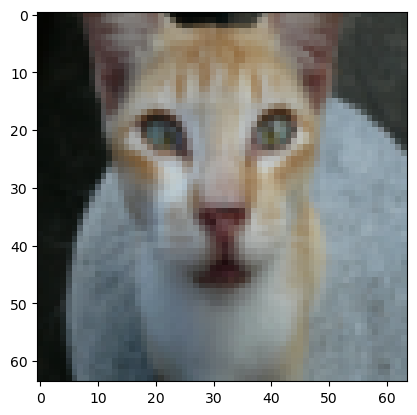

In [47]:
index = 11
a = plt.imshow(train_set_x_orig[index])
print("y = " + str(train_set_y[:, index]) + ", it's a ' " + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") + "' picture.")
plt.show()


In [52]:
m_train=train_set_x_orig.shape[0]
m_test=test_set_x_orig.shape[0]
num_px=test_set_x_orig.shape[1]

In [53]:
print (f"# of training examples: m_train = {m_train}")
print (f"# of test examples: m_test = {m_test}")
print (f"weight and height and # of channels respectively = {num_px}")
print (f"Shape of train_set_x = {train_set_x_orig.shape}")
print (f"Shape of train_set_y = {train_set_y.shape}")
print (f"Shape of test_set_x = {test_set_x_orig.shape}")
print (f"Shape of test_set_y = {test_set_y.shape}")

# of training examples: m_train = 209
# of test examples: m_test = 50
weight and height and # of channels respectively = 64
Shape of train_set_x = (209, 64, 64, 3)
Shape of train_set_y = (1, 209)
Shape of test_set_x = (50, 64, 64, 3)
Shape of test_set_y = (1, 50)


In [54]:
#reshaping and flattening the image

train_set_x_flatten=train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten=test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T  #transposing -- each column vector should be one training example

print("train_set_x_flatten shape :"+ str(train_set_x_flatten.shape))
print("train_set_y shape :"+ str(train_set_y.shape))
print("test_set_x_flatten shape :"+ str(test_set_x_flatten.shape))
print("test_set_y shape :"+ str(test_set_y.shape))


train_set_x_flatten shape :(12288, 209)
train_set_y shape :(1, 209)
test_set_x_flatten shape :(12288, 50)
test_set_y shape :(1, 50)


In [55]:
train_set_x=train_set_x_flatten/255
test_set_x=test_set_x_flatten/255  #standardizing dataset

In [57]:
#defining sigmoid (activation)

def sigmoid(z):
    s=1/(1+np.exp(-z))
    return s

In [58]:
#definign model params
def init_params(dim):
    w=np.zeroes((dim,1)) #dims= features
    b=0 #bias starting woth zero
    return w,b

In [ ]:
# forward and backward propagation
def propagate(w,b,X,Y):